In [1]:
#All neccesary classes for project

#general
import seaborn as sns
import scipy.stats as ss
import pandas as pd
import numpy as np
import os
import pickle
import time
import sys

#for preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf

#for machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

#for evaluation
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score

#for utility packages
from Utilities.utilities import import_data
from Utilities.utilities import DataFrameSelector
from Utilities.utilities import CategoricalEncoder
from Utilities.utilities import display_scores
from Utilities.utilities import pipeline_transform
from Utilities.utilities import reset_graph
from Utilities.models import DNN_Model
from Utilities.models import cross_val_score_dnn
from functools import partial

#image manipulation
from PIL import Image as PI
from resizeimage import resizeimage
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
import imagenet_helper_files.vgg_preprocessing
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import resnet_v2
import imagenet_helper_files.pnasnet as nas

#Import Custom Functions
from Utilities.model_builder import get_image
from Utilities.model_builder import get_file_lists
from Utilities.model_builder import parse_record
from Utilities.model_builder import get_batch
from Utilities.model_builder import build_iterator
from Utilities.bounded_model_builder import build_bounded_iterator
from Utilities.bounded_model_builder import build_dataset_bounded
from Utilities.bounded_model_builder import build_bounded_iterator_points
from Utilities.model_builder import get_values_imagenet
from Utilities.model_builder import get_values_bounded
from Utilities.model_builder import get_values_bounded_points
from Utilities.models import log_dir_build
from Utilities.utilities import generate_image
from Utilities.utilities import generate_image_array
from Utilities.cell_net_predictor import Binary_Categorical_Predictor
from Utilities.build_image_data_notebook import process_dataset


Using TensorFlow backend.


# Load the Data

Here we will load the training and validation data in order to do training

In [2]:
#Build tf_records
#Set Variables
validation_directory = "D:/Machine_Learning/Datasets/corpus_learning/validation"
train_directory = "D:/Machine_Learning/Datasets/corpus_learning/train"
output_directory = "D:/Machine_Learning/Datasets/corpus_learning/tf_records_2"

In [3]:
#Import TFRecords for both Training and Testing of the Dat
#Use the build_image_data.py to create these sets from your data

train_list, val_list = get_file_lists(output_directory)
train_list
val_list

['D:/Machine_Learning/Datasets/corpus_learning/tf_records_2\\validation-00000-of-00002',
 'D:/Machine_Learning/Datasets/corpus_learning/tf_records_2\\validation-00001-of-00002']

In [4]:
#Test pulling a piece of data out of the set to ensure that records were created properly
#Reset the graph 
reset_graph()

batch = 1
epochs = 1

#Build graph to get data
filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
training = tf.placeholder_with_default(True, shape=(), name = 'training')
handle = tf.placeholder(tf.string, shape=[], name="Dataset")

training_set = build_dataset_bounded(True, filename, batch_size, num_epochs, num_parallel_calls=8)
val_set = build_dataset_bounded(False, filename, batch_size, num_epochs, num_parallel_calls=8)

train_iterator = training_set.make_initializable_iterator()
val_iterator = val_set.make_initializable_iterator()



iterator = tf.data.Iterator.from_string_handle(
    handle, training_set.output_types, training_set.output_shapes)
next_data = iterator.get_next()
X, y_1,y_2,y_3,y_4, file = next_data


#Pull a sample piece of datas
with tf.Session() as sess:
        
    #Initialize Data
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    val_handle = sess.run(val_iterator.string_handle())
    
    X_val, Y_1,Y_2,Y_3,Y_4, file = sess.run(next_data, feed_dict={handle: val_handle})
    #means = sess.run(final_pool)
  

In [5]:
#build PDM
Y_val = np.array([])
Y_val = np.append(Y_val,Y_1)
Y_val = np.append(Y_val,Y_2)
Y_val = np.append(Y_val,Y_3)
Y_val = np.append(Y_val,Y_4)
Y_val

array([ 145.83612061,  164.41751099,  140.16934204,  199.95805359,
        143.47808838,  156.07022095,  180.33673096,  138.14031982])

In [6]:
#display an example and label

x_val = X_val.reshape(331,331,3)
y_val = Y_val
x_array = y_val[0:8:2] 
y_array = y_val[1:8:2]



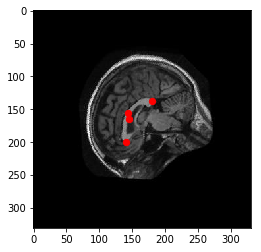

array([ 145.83612061,  164.41751099,  140.16934204,  199.95805359,
        143.47808838,  156.07022095,  180.33673096,  138.14031982])

In [7]:
from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.scatter(x=x_array, y=y_array, c='r', s=40)
plt.axis('on')
plt.show()
y_val

In [8]:
file

array([b'corpus_image_original_29_angle_225.jpg'], dtype=object)

# Build the Neural Network on top of Large Nas-Net

Here we will build the Nas-Net and then stack our own network on top

In [9]:

#import pnas_net model

#Nasnet Model Location
#Pretrained model location
nas_net_model = 'D:/AI/models/pnas_net/model.ckpt'

#Where Logs are going to go
landmark_ml_logs = 'D:/AI/models/landmark_ml/logs'
model_path = log_dir_build(landmark_ml_logs, "landmark_ml_points_v3")

#Where we save our model
landmark_ml_model = 'D:/AI/models/landmark_ml/model/landmark_ml_points_v3'
landmark_ml_model_best = 'D:/AI/models/landmark_ml/model/landmark_ml_points_best_v3'


In [10]:
#Reset the graph 
reset_graph()

#Set constants for Neural Network
dropout_rate = 0.01
learning_rate = 1
#n_hidden1 = 2000
n_hidden2 = 1000
n_hidden3 = 500
n_hidden4 = 100
n_hidden5 = 50
n_final_layer = 2



"""
#Placeholder for input data
X = tf.placeholder(tf.float32, shape=[None, 331, 331, 3], name="input")
y = tf.placeholder(tf.float32, shape=[None,8], name="bounding_box")
"""


#Set up Iterator to pull in data
filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
training = tf.placeholder_with_default(True, shape=(), name = 'training')
handle = tf.placeholder(tf.string, shape=[], name="Dataset")

training_set = build_dataset_bounded(True, filename, batch_size, num_epochs, num_parallel_calls=8)
val_set = build_dataset_bounded(False, filename, batch_size, num_epochs, num_parallel_calls=8)

train_iterator = training_set.make_initializable_iterator()
val_iterator = val_set.make_initializable_iterator()



iterator = tf.data.Iterator.from_string_handle(
    handle, training_set.output_types, training_set.output_shapes)
next_data = iterator.get_next()
X, y_1,y_2,y_3,y_4, file = next_data


#Define initalizer and batch normalization layers
bn_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)
he_init = tf.contrib.layers.variance_scaling_initializer()


#Import the Nas_Net and build it
with slim.arg_scope(nas.pnasnet_large_arg_scope()):
    net, end_points = nas.build_pnasnet_large(X, num_classes=1001, is_training=False)
    
    #A saver to load the pretrained Data
    saver = tf.train.Saver(name="Original_Saver")
    
    #For getting predictions from Original Network
    pnas_net_predictions = tf.get_default_graph().get_tensor_by_name("final_layer/predictions:0")
    
    #get indicies for doing reduction
    indices = tf.get_default_graph().get_tensor_by_name("final_layer/Mean/reduction_indices:0")
    
    #Load in the noder where we are going to connect our own network
    last_feature_node = tf.get_default_graph().get_tensor_by_name("cell_11/cell_output/concat:0")


with tf.name_scope("Landmark_ML"):
    #Use a stop layer to freeze all the layers beneath in Nas-Net
    
    with tf.name_scope("Isolate_Image_Features"):
        #get the output of the last cell layer
        stop_layer = tf.stop_gradient(last_feature_node)
        starting_relu = tf.nn.relu(stop_layer, name="first_relu")
        #starting_relu = tf.nn.relu(last_feature_node, name="first_relu")
        mean_pool = tf.reduce_mean(starting_relu, indices, name="condensing_mean")
        to_add = tf.constant([331,331], dtype=tf.float32)
        to_add_expanded = tf.expand_dims(to_add,0)
        concat_value = tf.tile(to_add_expanded, [tf.shape(mean_pool)[0], 1])
        
        
        final_pool = tf.concat([mean_pool, concat_value],1,name="Add_Size" )
        
    
    """
    with tf.name_scope("Hidden_Layer_1"):
        hidden1 = tf.layers.dense(mean_pool, n_hidden1, name="hidden1", kernel_initializer=he_init)
        #hidden1 = tf.layers.dense(last_feature_node, n_hidden1, name="hidden1", kernel_initializer=he_init)
        hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
        bn1 = bn_batch_norm_layer(hidden1_drop)
        bn1_act = tf.nn.relu(bn1)
    """
    
    with tf.name_scope("Hidden_Layer_2"):
        hidden2 = tf.layers.dense(final_pool, n_hidden2, name="hidden2", kernel_initializer=he_init)
        hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
        bn2 = bn_batch_norm_layer(hidden2_drop)
        bn2_act = tf.nn.relu(bn2)

    
    with tf.name_scope("Hidden_Layer_3"):
        hidden3 = tf.layers.dense(bn2_act, n_hidden3, name="hidden3", kernel_initializer=he_init)
        hidden3_drop = tf.layers.dropout(hidden3, dropout_rate, training=training)
        bn3 = bn_batch_norm_layer(hidden3_drop)
        bn3_act = tf.nn.relu(bn3) 
         
    with tf.name_scope("Hidden_Layer_4"):
        hidden4 = tf.layers.dense(bn3_act, n_hidden4, name="hidden4", kernel_initializer=he_init)
        hidden4_drop = tf.layers.dropout(hidden4, dropout_rate, training=training)
        bn4 = bn_batch_norm_layer(hidden4_drop)
        bn4_act = tf.nn.relu(bn4) 

    with tf.name_scope("Point_1_Estimator"):
        with tf.name_scope("Hidden_Layer_5_1"):
            hidden5_1 = tf.layers.dense(bn4_act, n_hidden5, name="hidden5_1", kernel_initializer=he_init)
            hidden5_drop_1 = tf.layers.dropout(hidden5_1, dropout_rate, training=training)
            bn5_1 = bn_batch_norm_layer(hidden5_drop_1)
            bn5_act_1 = tf.nn.relu(bn5_1) 


        with tf.name_scope("P1"):
            p1 = tf.layers.dense(bn5_act_1, n_final_layer, name="outputs_1", activation=tf.nn.relu)
        
    with tf.name_scope("Point_2_Estimator"):    
        with tf.name_scope("Hidden_Layer_5_2"):
            hidden5_2 = tf.layers.dense(bn4_act, n_hidden5, name="hidden5_2", kernel_initializer=he_init)
            hidden5_drop_2 = tf.layers.dropout(hidden5_2, dropout_rate, training=training)
            bn5_2 = bn_batch_norm_layer(hidden5_drop_2)
            bn5_act_2 = tf.nn.relu(bn5_2) 


        with tf.name_scope("P2"):
            p2 = tf.layers.dense(bn5_act_2, n_final_layer, name="outputs_2", activation=tf.nn.relu)

    with tf.name_scope("Point_3_Estimator"):            
        with tf.name_scope("Hidden_Layer_5_3"):
            hidden5_3 = tf.layers.dense(bn4_act, n_hidden5, name="hidden5_3", kernel_initializer=he_init)
            hidden5_drop_3 = tf.layers.dropout(hidden5_3, dropout_rate, training=training)
            bn5_3 = bn_batch_norm_layer(hidden5_drop_3)
            bn5_act_3 = tf.nn.relu(bn5_3) 

        with tf.name_scope("P3"):
            p3 = tf.layers.dense(bn5_act_3, n_final_layer, name="outputs_3", activation=tf.nn.relu)

    with tf.name_scope("Point_4_Estimator"):
        with tf.name_scope("Hidden_Layer_5_4"):
            hidden5_4 = tf.layers.dense(bn4_act, n_hidden5, name="hidden5_4", kernel_initializer=he_init)
            hidden5_drop_4 = tf.layers.dropout(hidden5_4, dropout_rate, training=training)
            bn5_4 = bn_batch_norm_layer(hidden5_drop_4)
            bn5_act_4 = tf.nn.relu(bn5_4) 

        with tf.name_scope("P4"):
            p4 = tf.layers.dense(bn5_act_4, n_final_layer, name="outputs_4", activation=tf.nn.relu)

    
    with tf.name_scope("Final_pdm"):
        final_pdm = tf.concat([p1,p2,p3,p4],1,name="final_pdm_tensor")
    
    with tf.name_scope("loss"):
            loss_1 = tf.losses.mean_squared_error(p1,y_1)
            loss_2 = tf.losses.mean_squared_error(p2,y_2)
            loss_3 = tf.losses.mean_squared_error(p3,y_3)
            loss_4 = tf.losses.mean_squared_error(p4,y_4)
            
            total_loss = loss_1 + loss_2 + loss_3 + loss_4
            
            loss_1_summary = tf.summary.scalar('loss_1', loss_1)
            loss_2_summary = tf.summary.scalar('loss_2', loss_2)
            loss_3_summary = tf.summary.scalar('loss_3', loss_3)
            loss_4_summary = tf.summary.scalar('loss_4', loss_4)
            loss_summary = tf.summary.scalar('loss_summary_total', total_loss)
            
    with tf.name_scope("train"):
        global_step = tf.Variable(0, trainable=False, name='global_step')
        
        #For momentum optomizer
        
        #decay_steps = 800
        #decay_rate = 1/8
        #learning_decay = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate)
        #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_decay, momentum=0.9, use_nesterov=True)
        
        #For BN
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

        with tf.control_dependencies(update_ops):
            training_op_1 = optimizer.minimize(loss_1, global_step=global_step)
            training_op_2 = optimizer.minimize(loss_2, global_step=global_step) 
            training_op_3 = optimizer.minimize(loss_3, global_step=global_step)
            training_op_4 = optimizer.minimize(loss_4, global_step=global_step)
            
        
            
#Variables for global initialization
saver2 = tf.train.Saver(name="Full_Saver")
init = tf.global_variables_initializer()

INFO:tensorflow:A GPU is available on the machine, consider using NCHW data format for increased speed on GPU.


In [ ]:
#Initialize all variables and restore the lower layer
#ERASES MODEL!!
with tf.Session() as sess:
    #Initalizer all variables
    init.run()
    
    #Restore the pretrained variables from Nas-Net
    saver.restore(sess, nas_net_model)
    
    
    #Save all of these variables to the new Cell_Net Model
    saver2.save(sess, landmark_ml_model)
    saver2.save(sess, landmark_ml_model_best)

In [ ]:
#For Exporting Graph
filewriter = tf.summary.FileWriter(model_path, tf.get_default_graph())

# Train the Network

Here we are going to train the network. Accuracy/Loss is recorded
Note for this version, a certain amount of the data is seen every training step. 
set train_size for how many images are trained on in each epoch
set batch_size for how many images are trained at once.
num_epochs is how many times the network sees that ammount of training data


In [ ]:
#For doing the initial training
#Total number of epochs to train
epochs = 200
steps_between_test_save = 1
batch = 30
train_size = 1700
all_data_steps = np.int(np.floor(train_size/batch))
lowest_loss = 10000
offset_correction = 37.5

#GPU Options
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth = True


with tf.Session(config=config) as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    saver2.restore(sess, landmark_ml_model)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #Initialize Data
    sess.run(train_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    val_handle = sess.run(val_iterator.string_handle())
    training_handle = sess.run(train_iterator.string_handle())
    
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):
        
            #run Training Op
            sess.run([training_op_1,training_op_2,training_op_3,training_op_4], feed_dict={handle: training_handle})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0 and step != 0) :
            
            loss_sum, loss_val, loss_s1, loss_s2, loss_s3, loss_s4 = sess.run([loss_summary, total_loss, 
                                                                               loss_1_summary, loss_2_summary,
                                                                               loss_3_summary, loss_4_summary], 
                                                                              feed_dict={training:False, 
                                                                                        handle: val_handle})
            
            
            filewriter.add_summary(loss_s1, step)
            filewriter.add_summary(loss_s2, step)
            filewriter.add_summary(loss_s3, step)
            filewriter.add_summary(loss_s4, step)
            filewriter.add_summary(loss_sum, step)
            print("Epoch: " + str(step) + " Loss: " + str(loss_val))
            saver2.save(sess, landmark_ml_model)
            
            if lowest_loss > loss_val:
                lowest_loss = loss_val
                saver2.save(sess, landmark_ml_model_best)
        step = step + 1
            
    #Finish the final Model
    saver2.save(sess, landmark_ml_model)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")
    print("Done!")

# Do metric testing

Here we will run through all of the training data and relate accuracy with confidence

In [11]:
landmark_ml_model = 'D:/AI/models/landmark_ml/model/landmark_ml_points_v3'
batch = 1
epochs = 574

#Set up frame
column_list = ['File', 'Estimated_PDM', 'Correct_PDM', 'L2-Loss']
full_data_frame = pd.DataFrame(columns=column_list)



with tf.Session() as sess:
    
    #Restore File
    saver2.restore(sess, landmark_ml_model)
    
    #Initialize Data
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    val_handle = sess.run(val_iterator.string_handle())
    
    for i in range(epochs):
        Y_1,Y_2, Y_3, Y_4,file_byte,Y_estimates,loss_values = sess.run([y_1,y_2,y_3,y_4, file,final_pdm, total_loss], 
                                                                  feed_dict={training:False, handle: val_handle})
        
        for j in range(batch):
            #Get File
            file_string = file_byte[j].decode("utf-8")
            
            #Get estimated PDM
            Estimated_PDM = Y_estimates[j]
            
            #Get Correct PDM
            Y_val = np.array([])
            Y_val = np.append(Y_val,Y_1[j])
            Y_val = np.append(Y_val,Y_2[j])
            Y_val = np.append(Y_val,Y_3[j])
            Y_val = np.append(Y_val,Y_4[j])
            
            #Get Loss
            losses = loss_values

            #Print to a pandas dataframe
            to_add = pd.DataFrame([[file_string,Estimated_PDM,Y_val,losses]], columns = column_list)
            full_data_frame = full_data_frame.append(to_add)
        print("Finished Epoch: " + str(i))

INFO:tensorflow:Restoring parameters from D:/AI/models/landmark_ml/model/landmark_ml_points_v3
Finished Epoch: 0
Finished Epoch: 1
Finished Epoch: 2
Finished Epoch: 3
Finished Epoch: 4
Finished Epoch: 5
Finished Epoch: 6
Finished Epoch: 7
Finished Epoch: 8
Finished Epoch: 9
Finished Epoch: 10
Finished Epoch: 11
Finished Epoch: 12
Finished Epoch: 13
Finished Epoch: 14
Finished Epoch: 15
Finished Epoch: 16
Finished Epoch: 17
Finished Epoch: 18
Finished Epoch: 19
Finished Epoch: 20
Finished Epoch: 21
Finished Epoch: 22
Finished Epoch: 23
Finished Epoch: 24
Finished Epoch: 25
Finished Epoch: 26
Finished Epoch: 27
Finished Epoch: 28
Finished Epoch: 29
Finished Epoch: 30
Finished Epoch: 31
Finished Epoch: 32
Finished Epoch: 33
Finished Epoch: 34
Finished Epoch: 35
Finished Epoch: 36
Finished Epoch: 37
Finished Epoch: 38
Finished Epoch: 39
Finished Epoch: 40
Finished Epoch: 41
Finished Epoch: 42
Finished Epoch: 43
Finished Epoch: 44
Finished Epoch: 45
Finished Epoch: 46
Finished Epoch: 47
Fin

Finished Epoch: 413
Finished Epoch: 414
Finished Epoch: 415
Finished Epoch: 416
Finished Epoch: 417
Finished Epoch: 418
Finished Epoch: 419
Finished Epoch: 420
Finished Epoch: 421
Finished Epoch: 422
Finished Epoch: 423
Finished Epoch: 424
Finished Epoch: 425
Finished Epoch: 426
Finished Epoch: 427
Finished Epoch: 428
Finished Epoch: 429
Finished Epoch: 430
Finished Epoch: 431
Finished Epoch: 432
Finished Epoch: 433
Finished Epoch: 434
Finished Epoch: 435
Finished Epoch: 436
Finished Epoch: 437
Finished Epoch: 438
Finished Epoch: 439
Finished Epoch: 440
Finished Epoch: 441
Finished Epoch: 442
Finished Epoch: 443
Finished Epoch: 444
Finished Epoch: 445
Finished Epoch: 446
Finished Epoch: 447
Finished Epoch: 448
Finished Epoch: 449
Finished Epoch: 450
Finished Epoch: 451
Finished Epoch: 452
Finished Epoch: 453
Finished Epoch: 454
Finished Epoch: 455
Finished Epoch: 456
Finished Epoch: 457
Finished Epoch: 458
Finished Epoch: 459
Finished Epoch: 460
Finished Epoch: 461
Finished Epoch: 462


In [12]:
#Print out the dataframe

full_data_frame.to_csv('Test_Run_Hard.csv', sep=',')
full_data_frame.to_excel('Validation_Data_PDM.xlsx')

In [ ]:
full_data_frame.describe()


# Make Figures from Test Data

Now that we have an estimate we can use it to make some figures

In [ ]:
#Get the location of the original files

image_folder = "D:/Machine_Learning/Datasets/corpus_learning/validation_data/"


In [ ]:
#Function for printing images
def print_cases(full_data_frame, image_folder,start, end):
    for i in range(start,end):
        
        filename = full_data_frame.iloc[i][0]
        file = str.split(filename, '.')[0]
        image = PI.open(image_folder + filename)
        pdm_guess = full_data_frame.iloc[i][1]
        x_guess = pdm_guess[0:8:2] - 37.5
        y_guess = pdm_guess[1:8:2] - 37.5
        pdm_real = full_data_frame.iloc[i][2]
        x_real = pdm_real[0:8:2] - 37.5
        y_real = pdm_real[1:8:2] - 37.5

        #Show PDM
        from matplotlib import pyplot as plt
        plt.imshow(image, interpolation='nearest')
        plt.axis('off')
        plt.savefig(filename)
        plt.close()

        from matplotlib import pyplot as plt
        plt.imshow(image, interpolation='nearest')
        plt.scatter(x=x_real, y=y_real, c='r', s=40)
        plt.axis('off')
        plt.savefig(file + '_pdm_real.jpg')
        plt.close()

        from matplotlib import pyplot as plt
        plt.imshow(image, interpolation='nearest')
        plt.scatter(x=x_guess, y=y_guess, c='r', s=40)
        plt.axis('off')
        plt.savefig(file + '_pdm_guess.jpg')
        plt.close()


In [ ]:
print_cases(full_data_frame, image_folder, 6,7)

In [ ]:
from matplotlib import pyplot as plt
full_data_frame.hist()
plt.grid(False)
plt.savefig('PDM_Loss_Distribution.jpg')